In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#define helper functions

#filter data by some targets
def filter_X(data, targets, column_name):
    if isinstance(targets, list): 
        filter = 0
        for target in targets:
            filter = filter | (data[column_name] == target)
        return (data[filter])
    else:
        raise TypeError("targets must be a list")

#jitter values by some small number
def jitter(values):
    stdev = .04 
    return values + np.random.randn(len(values)) * stdev
    

In [12]:
# summary of intelligible responses in SProd, WProd, and NProd
#proportion of intelligible responses per participant
#plot average intelligible response+error bars (SEM)

#import data and filter
data = pd.read_csv('../../data/all_prodloc_typing_output_20200804.csv')
print(data)

conditions = ["SPROD","WPROD","NPROD"]
data = filter_X(data, conditions, "Condition")

data = data.filter(["Condition","Response","SubjID"])

#new col where "unintelligible" responses are 0, everything else is 1

data['intelligible'] = [0 if response == "unintelligible" else 1 for response in data["Response"]]

subjects = np.unique(data["SubjID"])
num_subjects = len(subjects)
data["proportion_intelligible_mean"] = 0;
data["proportion_intelligible_std"] = 0;

#get proportion of intelligible responses per participant in each condition
for condition in conditions:
    for subject in subjects:
        temp_data = filter_X(data,[condition],"Condition");
        temp_data = filter_X(temp_data,[subject],"SubjID")

        total_n = len(temp_data['Response'])
        intelligible_n = sum(temp_data["intelligible"])

        proportion_intelligible = (intelligible_n/total_n)
        index = data[ (data['Condition']==condition) & (data["SubjID"]==subject) ].index
        data.loc[index, "proportion_intelligible_mean"] = proportion_intelligible
        data.loc[index, "proportion_intelligible_std"] = proportion_intelligible

data_to_plot = pd.pivot_table(data, values = ["proportion_intelligible_mean","proportion_intelligible_std"], index = "Condition", 
                                            aggfunc={'proportion_intelligible_mean': np.mean,
                                                     'proportion_intelligible_std': np.std})
data_to_plot["proportion_intelligible_stderr"] = data_to_plot["proportion_intelligible_std"]/math.sqrt(num_subjects)

means = [data_to_plot.loc[cond]["proportion_intelligible_mean"] for cond in conditions]
stderrs = [data_to_plot.loc[cond]["proportion_intelligible_stderr"] for cond in conditions]

data_to_plot_indiv = pd.pivot_table(data, values = ["proportion_intelligible_mean"], index = ["SubjID","Condition"])
data_to_plot_indiv.reset_index(inplace=True)
data_to_plot_indiv.set_index("Condition",inplace=True)

print(data_to_plot_indiv)

indiv_points = data_to_plot_indiv["proportion_intelligible_mean"] 

print(data_to_plot)

     Condition                                        Item  ItemNum  List  \
0          FIX                                           +        0     2   
1        WCOMP                   CHALK     STAIRS     FISH       40     2   
2        WCOMP  CHALK     BENCH     MICROSCOPE     CHICKEN       38     2   
3        WCOMP             HOLE     DEER     SWIMMING POOL        9     2   
4        WCOMP                 CHAIR     COCKTAIL     DEER       60     2   
...        ...                                         ...      ...   ...   
4126     WCOMP               SNOW     CLIFF     STRAWBERRY       81     1   
4127     WCOMP             CASTLE     DANDELION     VIOLIN      101     1   
4128     WCOMP           MAGNIFYING GLASS     BIRD     SKI       70     1   
4129     WCOMP                         HULA HOOP     SHIRT      103     1   
4130       FIX                                           +        0     1   

      Order   RT Response  Run             SubjID  TrialNumber  TrialOnset 

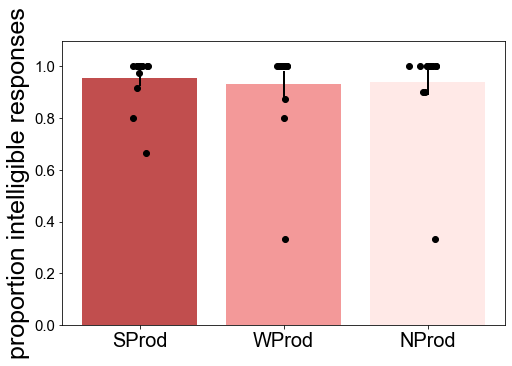

In [13]:
#plot the data
fig = plt.figure(figsize=(7,5),constrained_layout=True)
ax = fig.add_subplot()
color_dict = {'SPROD':'firebrick',
              'WPROD':'lightcoral',
              'NPROD':'mistyrose'}

linewidth = 2
capsize = 1

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

for ind, cond in enumerate(conditions):
    ax.scatter(x = jitter([ind for x in subjects]), 
               y = indiv_points.loc[cond],
               color = 'black',
               zorder = 2)
    ax.bar(x = ind,
           height = means[ind],
           yerr=stderrs[ind],
           alpha = 0.8,
           error_kw={'linewidth':linewidth, 'capsize':capsize, 'capthick':linewidth},
           color = color_dict[cond])

    

ax.set(title="",
       ylabel='proportion intelligible responses',
       xticks = [0,1,2],
       xticklabels= ['SProd','WProd','NProd'],
       ylim = (0,1.1))

#save plot
plt.savefig("../figures/typing_output_intelligible_responses.tiff")  

In [20]:
#bar graph with 3 bars showing avg (across subjects) proportion of well-formed 
#i) subject, ii), verb, and iii) post-verbal material, with error bars representing standard errors of the mean
#over participants and dots for ind participants.
data = [];
data = pd.read_csv('../../data/all_SPROD_annotated_data_20201210.csv',na_filter = False)

data = data[data['Response']!="Unintelligible"].copy() #exclude all unintelligible responses
data = data[data['Response']!="0"].copy() #exclude all missing values

subjects = np.unique(data["SubjID"])
num_subjects = len(subjects)

#get proportion of well formed subject, verb, and post-verbal material

targets = ["Subject_is_Well_Formed","Verb_is_Well_Formed","Post-Verb_is_Well_Formed"]

data = data.filter(targets + ["SubjID"])
data = data.replace(['NA','?', 'Unknown','Incomplete'], ["0","0","0","0"]) #replace all empty or other values with 0 (not well-formed)

data['Number_well_formed_elements'] = data['Subject_is_Well_Formed'].astype(int) + data['Verb_is_Well_Formed'].astype(int) +data['Post-Verb_is_Well_Formed'].astype(int)

num_well_formed = [0,1,2,3]

new_cols = [];
for subject in subjects:
    temp_data = filter_X(data,[subject],"SubjID")
    total_n = len(temp_data['SubjID'])
    index = data[ (data["SubjID"]==subject) ].index
    
    for num in num_well_formed:
        target_data = filter_X(temp_data,[num],'Number_well_formed_elements')
        target_n = len(target_data)
        
        target_proportion = (target_n/total_n)

        new_col_name = str(num) + "_well_formed_elements_proportion"
        new_cols.append(new_col_name)
        data.loc[index, new_col_name] = target_proportion
    
    for target in targets:
        target_data = [1 if x=="1" else 0 for x in temp_data[target]]
        target_n = sum(target_data)

        target_proportion = (target_n/total_n)

        new_col_name = target + "_proportion"
        new_cols.append(new_col_name)
        data.loc[index, new_col_name] = target_proportion

indiv_data = pd.pivot_table(data, values = new_cols, index = "SubjID")
indiv_data["group"] = 1;
mean_data = pd.pivot_table(indiv_data, values=new_cols, index = "group", aggfunc = np.mean)

std_data = pd.pivot_table(indiv_data,values=new_cols, index = "group", aggfunc = np.std)
stderr_data = std_data/math.sqrt(num_subjects)

#data.to_csv('../../data/processed_SProd_typing_output.csv')

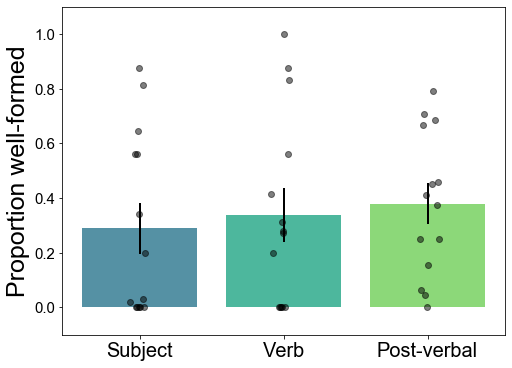

In [21]:
#plot proportion well formed for subject, verb, and post-verbal

targets = [target + "_proportion" for target in targets]

means = [mean_data[target] for target in targets]
stderrs = [stderr_data[target] for target in targets]
indiv_points = [[indiv_data[target]] for target in targets]

fig = plt.figure(figsize=(7,5),constrained_layout=True)
ax = fig.add_subplot()

my_cmap = plt.get_cmap("viridis")
color_starting_point = 2
multiplier_btwn_colors = 50

for ind, target in enumerate(targets):
    ax.bar(x = ind,
           height = means[ind],
           yerr=stderrs[ind],
           alpha = 0.8,
           error_kw={'linewidth':linewidth, 'capsize':capsize, 'capthick':linewidth},
           color = my_cmap.colors[(ind+color_starting_point)*multiplier_btwn_colors]
          )
    ax.scatter(x = jitter([ind for x in subjects]), 
               y = indiv_points[ind],
               color = 'black',
               alpha = 0.5,
               zorder = 2)
    
ax.set(title="",
       ylabel='Proportion well-formed',
       xticks = [0,1,2],
       xticklabels= ['Subject','Verb','Post-verbal'],
       ylim = (-0.1,1.1))

#save plot
plt.savefig("../figures/typing_output_SProd_S_V_PV_well_formedness.tiff")  
    

0
10
20
30
group
1    1.0
dtype: float64


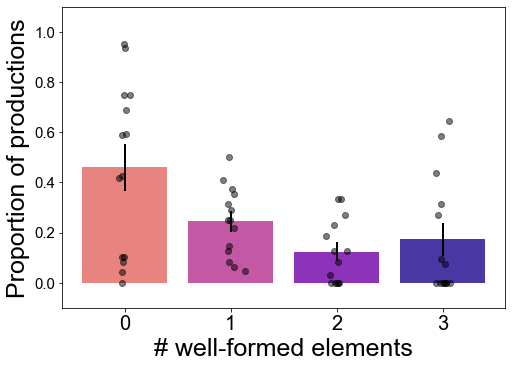

In [22]:
#for the proportion well formed productions, can we plot things in yet another way: 
#can we plot proportions of utterances that i) have no well-formed elements, 
#ii) have one well-formed element, iii) have two well-formed elements, and 
#iv) have all three well-formed elements 
#(these should add up to 1 for any given subject;
#not sure how to best visualize this, but there are probably a few ways that would work..) - Ev
targets = [str(num) + "_well_formed_elements_proportion" for num in num_well_formed]

means = [mean_data[target] for target in targets]
stderrs = [stderr_data[target] for target in targets]
indiv_points = [[indiv_data[target]] for target in targets]


fig = plt.figure(figsize=(7,5),constrained_layout=True)
ax = fig.add_subplot()

my_cmap = plt.get_cmap("plasma_r")
color_starting_point = 2
multiplier_btwn_colors = 50


for ind, target in enumerate(targets):
    print(ind*10)
    ax.bar(x = ind,
           height = means[ind],
           yerr=stderrs[ind],
           alpha = 0.8,
           error_kw={'linewidth':linewidth, 'capsize':capsize, 'capthick':linewidth},
           color = my_cmap.colors[(ind+color_starting_point)*multiplier_btwn_colors]
          )
    ax.scatter(x = jitter([ind for x in subjects]), 
               y = indiv_points[ind],
               color = 'black',
               alpha = 0.5,
               zorder = 2)
    
ax.set(title="",
       ylabel='Proportion of productions',
       xlabel = '# well-formed elements',
       xticks = [0,1,2,3],
       xticklabels= ['0','1','2','3'],
       ylim = (-0.1,1.1))

#save plot
plt.savefig("../figures/typing_output_SProd_num_elements_well_formed.tiff")  

print(sum(means))